In [11]:
from plotting import imshow
import torch
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2

### Pickle functions for opening and saving

In [12]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def save_pickle(file, data):
    with open(file, 'wb') as fo:
        pickle.dump(data, fo)

In [13]:
# RGB training data load
train_set = unpickle('train')

# Image names 
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]

# Getting the images
images_data = train_set[b'data'].copy() 


### Data loading function to create tensors from the pickled data

In [14]:
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # image name
        self.images_data = images_data # image data
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3,32,32)  # (C, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, C)

       
        if self.transform:
            img = self.transform(img)

        return img, self.filenames[idx]

# Normalization and transforming to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

### Functions for color scale conversions

In [15]:
# Input tensor(C,H,W) -> output tensor(H,W,C)
def rgb_yuv(array):
    new_array = array.permute(1,2, 0).numpy().copy()
    return torch.Tensor(cv2.cvtColor(new_array, cv2.COLOR_RGB2YUV))

# Input tensor(H,W,C) -> output tensor(C,H,W)
def yuv_rgb(array):
    new_array = array.numpy().copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    return torch.tensor((new_array*255).astype(np.uint8)).permute(2, 0, 1)

### Creating the YUV scaled images

In [16]:
# Loading the RGB images
dataset = CustomDataset(filenames=filenames, images_data=images_data,transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle = False)

In [17]:
all_yuv = []
for batch in train_loader:
    image_tensor, filename = batch  # Extract data from the batch
    for idx, image_rgb in enumerate(image_tensor):
        
        img_yuv = rgb_yuv(image_rgb)
        # Renormalizing and transforming to numpy array
        all_yuv.append((img_yuv*255).numpy().astype("uint8")) 

In [18]:
# Reshaping to match b'data' style
all_yuv_array = np.array(all_yuv).reshape(images_data.shape)

# Create new dictionary with the same structure
yuv_train_set = train_set.copy()

yuv_train_set[b'data'] = all_yuv_array
save_pickle('yuv_train', yuv_train_set)

### Loading YUV image dataset

In [19]:
yuv_train_set = unpickle('yuv_train')

yuv_images_data = yuv_train_set[b'data']

yuv_dataset = CustomDataset(filenames=filenames, images_data=yuv_images_data, transform=transform)
yuv_train_loader = DataLoader(yuv_dataset, batch_size=32, shuffle = False)

/Users/mihriban/Desktop/Colorization/.venv/lib/python3.11/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Filename: bos_taurus_s_000507.png


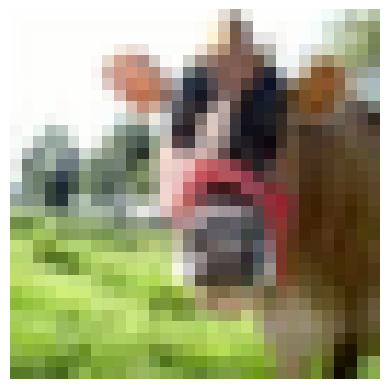

In [20]:
for batch in yuv_train_loader:
    image_tensor, filename = batch  # Extract data from the batch

    image_yuv = image_tensor[0]  # Frist image of the batch (YUV)

    # Need to resize first
    rgb_output = yuv_rgb(image_yuv.resize(32, 32,3))

    print(f"Filename: {filename[0]}")

    imshow(rgb_output) 
    break